# Manipulating Voices in Praat

## Input relevant modules

In [1]:
import parselmouth
from parselmouth.praat import call
from IPython.display import Audio

## Load and play original sound

In [3]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")
Audio(data=sound.values, rate=sound.sampling_frequency)
sound.get_power()

1.6005083348681327e-05

## Normalizing amplitude

Normalizing amplitude means making all of the sounds the same volume.  There are two different methods.  In most experiments, you'll want to normalize using RMS because we want to chagne the average volume.  However, peak normalization also has it's place.

### Peak vs RMS  

- Peak normalization raises or lowers the amplitude so that the loudest peak is at the maximum value
    - Pro's  
        - Use this to avoid clipping  
    - Con's  
        - Does not change average loudness of sound
- RMS (root-mean-squared)  
    - Pro's  
        - Alters average loudness of sound
    - Con's  
        - Allows clipping to occur

## Peak amplitude in pascals

Reset sound to make sure it's at it's original amplitude

In [4]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")

### Measure peak by getting the loudest sample

In [5]:
sound.get_maximum()

0.04058837890625

## Peak Amplitude Normalization

In [6]:
sound.scale_peak(99)
sound.get_maximum()

99.0

Reset sound to make sure it's at it's original amplitude

In [ ]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")

## RMS Amplitude Normalization in dB

In [7]:
sound.scale_intensity(70)
sound.get_intensity()

70.00000000000001

# Reversing sounds

Reversing sounds is an important control condition for many experiments.

Reset the sound

In [8]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")

### Reverse the sound

In [9]:
sound.reverse()

### Play the reversed sound

In [10]:
Audio(data=sound.values, rate=sound.sampling_frequency)

# Resampling sounds

### Reset sound 

In [11]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")

### Find sampling rate

In [12]:
sampling_rate = sound.sampling_frequency
print(sampling_rate)

48000.0


### Resample the sound

In [13]:
resampled_sound = sound.resample(123456)

### Check your work

In [14]:
new_sampling_rate = resampled_sound.sampling_frequency
print(new_sampling_rate)

123456.0


# Pitch Manipulation

## Scaling the pitch

Reset the sound

In [15]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")

### Create a manipulation object

In [16]:
manipulation = call(sound, "To Manipulation", 0.001, 75, 600)
print(manipulation)

Object type: Manipulation
Object name: untitled
Date: Mon Feb  3 22:13:45 2020

Domain:
   xmin: 0
   xmax: 3.3032916666666665



### Extract the Pitch Tier

A pitch tier contains the pitch values over time

In [17]:
pitch_tier = call(manipulation, "Extract pitch tier")
print(pitch_tier)

Object type: PitchTier
Object name: untitled
Date: Mon Feb  3 22:13:52 2020

Time domain:
   Start time: 0 seconds
   End time: 3.3032916666666665 seconds
   Total duration: 3.3032916666666665 seconds
Number of points: 986
Minimum pitch value: 79.34170452361391 Hz
Maximum pitch value: 159.18842472391276 Hz



### A pitch tier looks like this (even though this isn't a pitch tier)

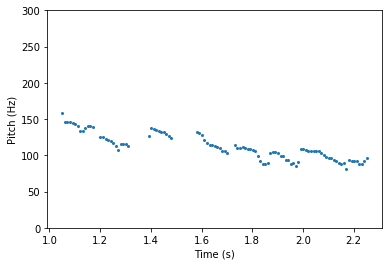

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


def draw_pitch(pitch):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values == 0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, 300)
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch (Hz)")


pitch = sound.to_pitch()
draw_pitch(pitch)

### Multiply the Pitch Tier

This will multiply every pitch point in the sound by the factor we specify

In [19]:
call(pitch_tier, "Multiply frequencies", sound.xmin, sound.xmax, 2)

### Replace the original pitch tier with the new one we just made

In [20]:
call([pitch_tier, manipulation], "Replace pitch tier")

### Resynthesize the sound

In [21]:
sound_octave_up = call(manipulation, "Get resynthesis (overlap-add)")

### Play the original sound

In [22]:
Audio(data=sound.values, rate=sound.sampling_frequency)

### Play the manipulated sound

In [23]:
Audio(data=sound_octave_up.values, rate=sound_octave_up.sampling_frequency)

## Shifting pitch

Reset the sound

In [24]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")

### Repeat the first two steps

In [25]:
manipulation = call(sound, "To Manipulation", 0.001, 75, 600)
pitch_tier = call(manipulation, "Extract pitch tier")

### Instead of `Multiply frequencies`, we `Shift frequencies`, and here we also specify a `Unit` as `Hertz`

In [26]:
call(pitch_tier, "Shift frequencies", sound.xmin, sound.xmax, -30, "Hertz")

### Repeat the last 2 steps

In [27]:
call([pitch_tier, manipulation], "Replace pitch tier")
shifted_sound = call(manipulation, "Get resynthesis (overlap-add)")

### Play the original sound

In [28]:
Audio(data=sound.values, rate=sound.sampling_frequency)

### Play the manipulated sound

In [29]:
Audio(data=shifted_sound.values, rate=shifted_sound.sampling_frequency)

### Interactive pitch manipulations

In [30]:
import ipywidgets
import glob


def change_pitch(sound, factor):
    manipulation = call(sound, "To Manipulation", 0.001, 75, 600)
    pitch_tier = call(manipulation, "Extract pitch tier")
    call(pitch_tier, "Multiply frequencies", sound.xmin, sound.xmax, factor)
    call([pitch_tier, manipulation], "Replace pitch tier")
    manipulated_sound = call(manipulation, "Get resynthesis (overlap-add)")
    return manipulated_sound


def interactive_change_pitch(audio_file, factor):
    sound = parselmouth.Sound(audio_file)
    sound_changed_pitch = change_pitch(sound, factor)
    return Audio(data=sound_changed_pitch.values, rate=sound_changed_pitch.sampling_frequency)


w = ipywidgets.interact(interactive_change_pitch,
                        audio_file=ipywidgets.Dropdown(options=sorted(glob.glob(
                            "*.wav")), value="03-01-01-01-01-01-01.wav"),
                        factor=ipywidgets.FloatSlider(min=0.25, max=2, step=0.05, value=1))

interactive(children=(Dropdown(description='audio_file', options=('/home/david/Desktop/03-01-01-01-01-01-01.wa…

In [31]:
def change_pitch(sound, factor):
    manipulation = call(sound, "To Manipulation", 0.001, 75, 600)
    pitch_tier = call(manipulation, "Extract pitch tier")
    call(pitch_tier, "Shift frequencies",
         sound.xmin, sound.xmax, factor, "Hertz")
    call([pitch_tier, manipulation], "Replace pitch tier")
    manipulated_sound = call(manipulation, "Get resynthesis (overlap-add)")
    return manipulated_sound


def interactive_change_pitch(audio_file, factor):
    sound = parselmouth.Sound(audio_file)
    sound_changed_pitch = change_pitch(sound, factor)
    return Audio(data=sound_changed_pitch.values, rate=sound_changed_pitch.sampling_frequency)


w = ipywidgets.interact(interactive_change_pitch,
                        audio_file=ipywidgets.Dropdown(options=sorted(glob.glob(
                            "*.wav")), value="03-01-01-01-01-01-01.wav"),
                        factor=ipywidgets.FloatSlider(min=-100, max=100, step=2, value=1))

interactive(children=(Dropdown(description='audio_file', options=('/home/david/Desktop/03-01-01-01-01-01-01.wa…

# Formant manipulation

This will raise and lower all formants in a sound.  The method 

Overriding a sampling frequency is a bad way to manipulate pitch because it changes all of the frequencies and it changes time

In [32]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")
sound.override_sampling_frequency(70000)
Audio(data=sound.values, rate=sound.sampling_frequency)

### Overriding the sampling rate
- Speeds up or slow down a sound by first resampling a sound. 
    - Multiplies or divides the number of samples in the sound.  
    
- Overriding the sampling rate  
    -Play samples at a specified sampling rate, regardless of what the file says the sampling rate is.  

This will also raise or lower all of the frequencies.  If we do nothing else, this is a poor manipulation.

### Load the sound

In [33]:
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")

### Pick how much we want to manipulate the formants by

In [34]:
manipulation_factor = 2

### Get the sampling rate

In [35]:
sampling_rate = sound.sampling_frequency
print(sampling_rate)

48000.0


### Get the duration of the sound

In [36]:
duration = sound.get_total_duration()
print(f'Orignial duration {duration}')

Orignial duration 3.3032916666666665


### Resample the sound

In [37]:
resampled_sound = sound.resample(sampling_rate*manipulation_factor, 50)
print(resampled_sound.sampling_frequency)

96000.0


### Override the sampling ratie

In [38]:
resampled_sound.override_sampling_frequency(sampling_rate)
print(resampled_sound.sampling_frequency)

48000.0


### We have doubled the length of our sound by doubling the number of frequencies (when resampling to double the sampling rate) and playing the samples at half the rate (the original sampling rate).

In [39]:
print(f'Orignial duration {duration}')
print(f"Final duration {resampled_sound.get_total_duration()}")

Orignial duration 3.3032916666666665
Final duration 6.606583333333333


In [40]:
Audio(data=resampled_sound.values, rate=resampled_sound.sampling_frequency)

## We can stretch time back to where it was

### Repeat steaps 1-4

In [41]:
sampling_rate = sound.sampling_frequency
manipulation_factor = 2
duration = sound.get_total_duration()
print(f'orignial duration {duration}')

orignial duration 3.3032916666666665


### Time warp

In [42]:
manipulation = call(sound, "To Manipulation", 0.001, 75, 600)

#### Create a duration tier

In [43]:
duration_tier = call("Create DurationTier", "empty", 0, duration)

#### Add a point to the duration tier the length of the manipulation factor to offset time change due to resampling and overriding the sampling rate.

In [44]:
call(duration_tier, "Add point", 0, manipulation_factor)

#### Replace the original duration tier with the one we just created

In [45]:
call([duration_tier, manipulation], "Replace duration tier")

#### Resynthesize the sound

In [46]:
time_streched_sound = call(manipulation, "Get resynthesis (overlap-add)")

#### Measure the new duration

In [47]:
print(f"Time stretched duration {time_streched_sound.get_total_duration()}")

Time stretched duration 6.606583333333333


#### Resample the sound based on the inverse of the manipulation factor   
To raise pitch we need to decrease the sampling rate and override
To lower pitch we need to increase the sampling rate and override

In [48]:
resampled_sound = time_streched_sound.resample(
    sampling_rate * (1 / manipulation_factor), 50)

#### Override the manipulated sampling rate to the original rate

In [49]:
resampled_sound.override_sampling_frequency(sampling_rate)

In [50]:
print(f'orignial duration {duration}')
print(f"Final duration {resampled_sound.get_total_duration()}")
Audio(data=resampled_sound.values, rate=resampled_sound.sampling_frequency)

orignial duration 3.3032916666666665
Final duration 3.3032916666666665


### Then put pitch back where it was

#### Repeat steps 1-5

In [51]:
sampling_rate = sound.sampling_frequency
manipulation_factor = 2
duration = sound.get_total_duration()
print(f'orignial duration {duration}')
manipulation = call(sound, "To Manipulation", 0.001, 75, 600)

orignial duration 3.3032916666666665


#### Get the pitch

In [52]:
pitch = sound.to_pitch()
print(f"Original pitch {call(pitch, 'Get mean', 0, 0, 'Hertz')}")

Original pitch 111.84901197921828


#### Create a PitchTier from the pitch

In [53]:
pitch_tier = call(pitch, "Down to PitchTier")

#### Change pitch to 1/manipulation factor to compensate for raising and lowering by resampling and overriding the sampling rate.

In [54]:
call(pitch_tier, "Formula", f"self*{1/manipulation_factor}")

#### Replate the original pitch tier with the manipulated one

In [55]:
call([pitch_tier, manipulation], "Replace pitch tier")

#### Repeat duration manipulation

In [56]:
duration_tier = call("Create DurationTier", "empty", 0, duration)
call(duration_tier, "Add point", 0,  manipulation_factor)
call([duration_tier, manipulation], "Replace duration tier")
time_streched_sound = call(manipulation, "Get resynthesis (overlap-add)")

In [57]:
print(f'orignial duration {duration}')
print(f"Time stretched duration {time_streched_sound.get_total_duration()}")

orignial duration 3.3032916666666665
Time stretched duration 6.606583333333333


#### Resample the sound and override the sampling rate

In [58]:
resampled_sound = time_streched_sound.resample(
    sampling_rate*(1/manipulation_factor), 50)
resampled_sound.override_sampling_frequency(sampling_rate)

#### Check our manipulation

In [59]:
pitch = resampled_sound.to_pitch()
print(f"Final pitch {call(pitch, 'Get mean', 0, 0, 'Hertz')}")
print(f"Final duration {resampled_sound.get_total_duration()}")
Audio(data=resampled_sound.values, rate=resampled_sound.sampling_frequency)

Final pitch 111.96060000693238
Final duration 3.3032916666666665


### After doing the above for 10 years, Praat added a button for the Pitch and Formant manipulation and called it "Change Gender"

In [60]:
factor = 2
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")
manipulated_sound = call(sound, "Change gender", 75, 500, factor, 0, 1, 1)
Audio(data=manipulated_sound.values, rate=resampled_sound.sampling_frequency)

### Example: Raise Pitch and Shift Formants

In [61]:
factor = 2
sound = parselmouth.Sound("03-01-01-01-01-01-01.wav")
pitch = sound.to_pitch()
medain_pitch = call(pitch, "Get quantile", 0, 0, 0.5, "Hertz")
pitch_shift = medain_pitch + 60
manipulated_sound = call(sound, "Change gender", 100,
                         500, factor, pitch_shift, 1, 1)
Audio(data=manipulated_sound.values, rate=resampled_sound.sampling_frequency)